# XAI LIME applied to XGBRegressor

Load trained XGBRegressor

In [2]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from faa_p2.config import CLEAN_DATA_FILE, MODELS, RANDOM_STATE, DATA_SPLIT_RATIO, XGBR

# ============ load data + model ============
df = pd.read_csv(CLEAN_DATA_FILE, index_col=0)
y = df["medv"]
X = df.drop(columns=["medv"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=DATA_SPLIT_RATIO, random_state=RANDOM_STATE
)

model = joblib.load(MODELS[XGBR]["filename"])

In [7]:
# ============ LIME ============
from lime.lime_tabular import LimeTabularExplainer

# LIME initialization
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode="regression",
    discretize_continuous=True,
    random_state=RANDOM_STATE,
)

# explain one test instance
idx = 0
x_row = X_test.iloc[idx]
y_true = float(y_test.iloc[idx])
y_pred = float(model.predict(x_row.to_frame().T)[0])

print(f"Explaining test instance idx={idx}")
print(f"True value (y): {y_true:.3f}")
print(f"Model prediction: {y_pred:.3f}")

Explaining test instance idx=0
True value (y): 28.200
Model prediction: 30.026


### Top 10 most influent features

LIME explanation (top 10):
rm > 6.63                                -> +4.2036
7.09 < lstat <= 11.46                    -> +2.1320
crim <= 0.08                             -> -1.1592
tax <= 277.00                            -> +0.7864
indus <= 5.19                            -> +0.6308
17.23 < ptratio <= 19.00                 -> +0.5515
b > 396.16                               -> -0.4019
chas <= 0.00                             -> -0.2985
5.00 < rad <= 24.00                      -> +0.2720
0.45 < nox <= 0.54                       -> +0.2354


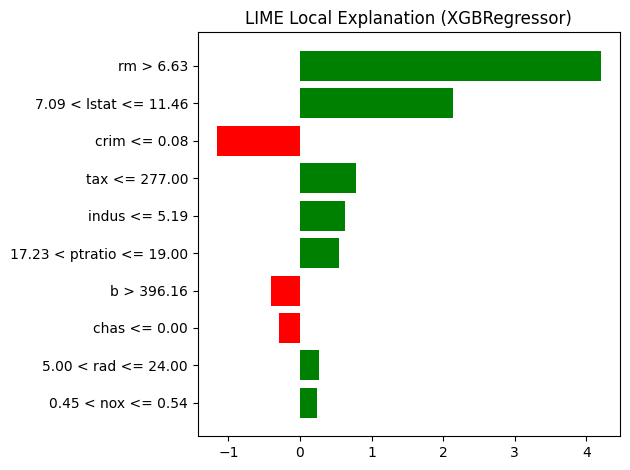

In [8]:
exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[idx].values,
    predict_fn=model.predict,  # returns a 1D array for regression
    num_features=10,
)

print("LIME explanation (top 10):")
for rule, weight in exp.as_list():
    print(f"{rule:40s} -> {weight:+.4f}")

# show in notebook (HTML)
#xp.show_in_notebook(show_table=True)

fig = exp.as_pyplot_figure()
plt.title("LIME Local Explanation (XGBRegressor)")
plt.tight_layout()
plt.show()

### **LIME local explanation** (XGBRegressor)
Biggest upward pushes:
- **`rm > 6.63` → +4.2036**: many rooms strongly increases the predicted price.
- **`7.09 < lstat <= 11.46` → +2.1320**: this `lstat` range increases the prediction (locally for this case).
- Smaller upward effects: **`tax <= 277` (+0.7864)**, **`indus <= 5.19` (+0.6308)**, **`ptratio` in (17.23, 19] (+0.5515)**, **`rad` (+0.2720)**, **`nox` (+0.2354)**.

Downward pushes:
- **`crim <= 0.08` → −1.1592**: in this example, this feature decreases the prediction.
- **`b > 396.16` → −0.4019**, **`chas <= 0` → −0.2985**: smaller negative effects.